# Watersheds for Supervised Classification

In this notebook we present a few results on using watersheds for supervised classification. We use a variant of the MSF-watershed as cited in [1](https://hal-upec-upem.archives-ouvertes.fr/hal-00622410/document) for supervised classification.


All the relevant implementations are in "utils.py". 

Links:

[1] https://hal-upec-upem.archives-ouvertes.fr/hal-00622410/document


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import time

from utils import *

%matplotlib inline


from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RFC


# Visualizing the boundaries

We start with trying to understand the how the boundaries of using watershed as classifier behave? Note that MSF-watershed requires both the train and test data to be presented before training. However, as discussed in the accompanying article, one can use 1-Nearest Neighbor classifier to classify new points and this would result in equivalent labelling! (Thanks to PRIM's MST algorithm)

We use this techinique to visualize the boundaries!!

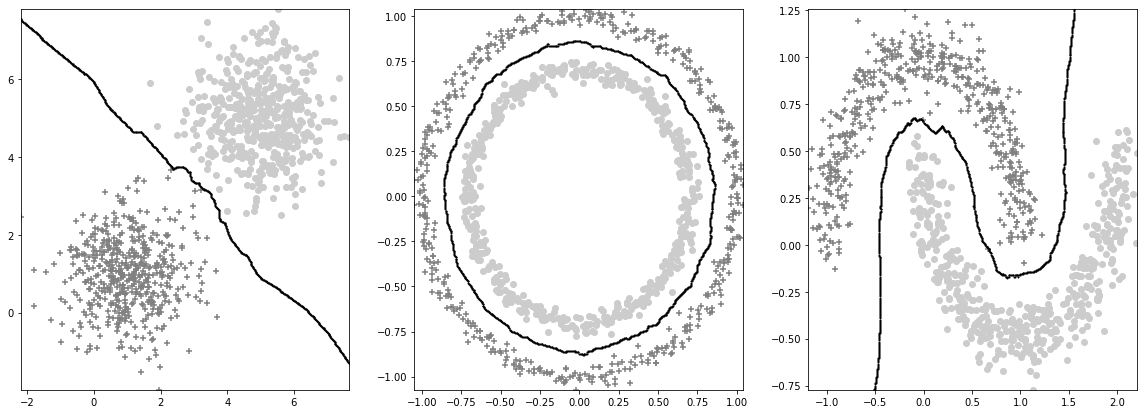

In [3]:
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.neighbors import kneighbors_graph

np.random.seed(10)

size_data = 1000
percent_seeds = 0.1
X, y = make_blobs(size_data, n_features=2, centers=[[1,1], [5,5]], cluster_std=1.0)
graph = kneighbors_graph(X, n_neighbors=20, mode='distance')
seeds = np.zeros(size_data, dtype=np.int32)

for label in np.unique(y):
    ind_label = np.where(y==label)[0]
    ind = np.random.choice(ind_label, size=int(percent_seeds*(ind_label.shape[0])))
    seeds[ind] = label+1
    
y_watershed = watershed_supervised(graph, seeds)

bx, by = plot_boundary(X, y_watershed, resolution=400, n_neighbors=5)
xmin, xmax, ymin, ymax = np.min(X[:,0]), np.max(X[:,0]), np.min(X[:,1]), np.max(X[:,1])
color = np.array([x for x in 'bgrcmykw']*10)

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.axis([xmin, xmax, ymin, ymax])
ind = np.where(y_watershed == 1)
plt.scatter(X[ind,0], X[ind,1], marker='+', c='0.5')
ind = np.where(y_watershed == 2)
plt.scatter(X[ind,0], X[ind,1], marker='o', c='0.8')
plt.scatter(bx, by, s=1,c='k')
plt.savefig("./img/example1.eps", dpi=400, cmap=plt.cm.gray)


size_data = 1000
percent_seeds = 0.1
X, y = make_circles(n_samples=size_data, noise=0.03, factor=0.7)
graph = kneighbors_graph(X, n_neighbors=20, mode='distance')
seeds = np.zeros(size_data, dtype=np.int32)

for label in np.unique(y):
    ind_label = np.where(y==label)[0]
    ind = np.random.choice(ind_label, size=int(percent_seeds*(ind_label.shape[0])))
    seeds[ind] = label+1
    
y_watershed = watershed_supervised(graph, seeds)

bx, by = plot_boundary(X, y_watershed, resolution=400, n_neighbors=5)
xmin, xmax, ymin, ymax = np.min(X[:,0]), np.max(X[:,0]), np.min(X[:,1]), np.max(X[:,1])
color = np.array([x for x in 'bgrcmykw']*10)

plt.subplot(1,3,2)
plt.axis([xmin, xmax, ymin, ymax])
ind = np.where(y_watershed == 1)
plt.scatter(X[ind,0], X[ind,1], marker='+', c='0.5')
ind = np.where(y_watershed == 2)
plt.scatter(X[ind,0], X[ind,1], marker='o', c='0.8')
plt.scatter(bx, by, s=1,c='k')
plt.savefig("./img/example2.eps", dpi=400, cmap=plt.cm.gray)


size_data = 1000
percent_seeds = 0.1
X, y = make_moons(n_samples=size_data, noise=0.1)
graph = kneighbors_graph(X, n_neighbors=20, mode='distance')
seeds = np.zeros(size_data, dtype=np.int32)

for label in np.unique(y):
    ind_label = np.where(y==label)[0]
    ind = np.random.choice(ind_label, size=int(percent_seeds*(ind_label.shape[0])))
    seeds[ind] = label+1
    
y_watershed = watershed_supervised(graph, seeds)

bx, by = plot_boundary(X, y_watershed, resolution=400, n_neighbors=5)
xmin, xmax, ymin, ymax = np.min(X[:,0]), np.max(X[:,0]), np.min(X[:,1]), np.max(X[:,1])
color = np.array([x for x in 'bgrcmykw']*10)

plt.subplot(1,3,3)
plt.axis([xmin, xmax, ymin, ymax])
ind = np.where(y_watershed == 1)
plt.scatter(X[ind,0], X[ind,1], marker='+', c='0.5')
ind = np.where(y_watershed == 2)
plt.scatter(X[ind,0], X[ind,1], marker='o', c='0.8')
plt.scatter(bx, by, s=1,c='k')
plt.savefig("./img/example3.eps", dpi=400, cmap=plt.cm.gray)



# Experiments on High Dimensional Data

The following algorithms in utils.py are used

1. IFT(graph, seeds, alg='SP-SUM')
2. RW(graph, seeds, beta=5., eps=1e-6)
3. powerWatershed_multipleLabels(graph, seeds, bucketing='kmeans', eps=1e-2, k=3, beta=5., eps_weight=1e-6)
4. ensemble_watershed(X, graph, seeds, number_estimators=10, num_features_select=20, percentage_seed_select = 80, gt=None) 
5. watershed_supervised(graph, seeds)
6. SVM (From Sklearn)
7. 1-NearestNeighbor (From Sklearn)
8. RandomForest (From Sklearn)

The SSL datasets are used. The function "get_data(name)" returns the data. 

Possible Parameters:
* IFT : alg='SP-SUM'
* RW : beta in [1,3,5] and eps=[1e-6]
* powerWatershed_multipleLabels : k in [3,5,10], beta in [1,3,5]
* ensemble_watershed: number_estimators=100,  num_features_select in [20,30,50]%
* SVM : C in [0.1, 1., 3.]
* 1-NN (Nothing)
* RandomForest : num_features_select in [20,30,50]%

20% of the data is used for training!

In [4]:
percent_train = 20
for iIter in range(20):
    with open("./results/results_percentTrain"+str(percent_train)+"Iter"+str(iIter)+".csv", 'w') as f:
        f.write("id,method,dataset,paramters,accuracy,time")
        f.write("\n")
        count = 0
        for dataset in ['SSL1', 'SSL2', 'SSL3','SSL4', 'SSL5','SSL6', 'SSL7']:
            X, y, graph = get_data(dataset)
            y = y.ravel()
            seeds = np.zeros(X.shape[0], dtype=np.int32)
            for label in np.unique(y):
                tmp = np.where(y==label)[0]
                indSelect = np.random.choice(tmp, int(0.01*percent_train*tmp.shape[0]), replace=False)
                seeds[indSelect] = label
                assert label > 0, "GT Label is 0 for some dataset. Please check..."

            # Watershed Supervised
            tic = time.time()
            y_watershed = watershed_supervised(graph,seeds)
            toc = time.time()
            acc_watershed = np.mean(y_watershed[seeds==0]==y[seeds==0])
            f.write(str(count)+","+"watershed"+","+dataset+","+"NA"+","+str(acc_watershed)+","+str(toc-tic))
            f.write("\n")
            count += 1
            print("Watershed for {} done...".format(dataset))

            # IFT-SUM
            tic = time.time()
            y_IFT = IFT(graph, seeds, alg='SP-SUM')
            toc = time.time()
            acc_IFT = np.mean(y_IFT[seeds==0]==y[seeds==0])
            f.write(str(count)+","+"IFT-SUM"+","+dataset+","+"NA"+","+str(acc_IFT)+","+str(toc-tic))
            f.write("\n")
            count += 1
            print("IFT-SUM for {} done...".format(dataset))

            # RW
            for beta in [1., 3., 5.]:
                tic = time.time()
                y_RW = RW(graph, seeds, beta=beta, eps=1e-6)
                toc = time.time()
                acc_RW = np.mean(y_RW[seeds==0]==y[seeds==0])
                f.write(str(count)+","+"RW"+","+dataset+","+"beta="+str(beta)+","+str(acc_RW)+","+str(toc-tic))
                f.write("\n")
                count += 1
                print("RW for {} with param beta={} done...".format(dataset, beta))


            # Power Watershed
            for beta in [1., 3., 5.]:
                for k in [1,3,5,10]:
                    tic = time.time()
                    y_PW = powerWatershed_multipleLabels(graph, seeds, bucketing='kmeans', eps=1e-2, k=k, beta=beta, eps_weight=1e-6)
                    toc = time.time()
                    acc_PW = np.mean(y_PW[seeds==0]==y[seeds==0])
                    f.write(str(count)+","+"PW"+","+dataset+","+"beta="+str(beta)+",k="+str(k)+","+str(acc_PW)+","+str(toc-tic))
                    f.write("\n")
                    count += 1
                    print("PW for {} with param beta={} k={} done...".format(dataset, beta, k))


            # SVM
            for C in [0.1, 1., 3.]:
                clf = SVC(C=C, gamma='auto')
                tic = time.time()
                clf.fit(X[seeds>0],y[seeds>0])
                y_SVM = clf.predict(X)
                toc = time.time()
                acc_SVM = np.mean(y_SVM[seeds==0]==y[seeds==0])
                f.write(str(count)+","+"SVM"+","+dataset+","+"C="+str(C)+","+str(acc_SVM)+","+str(toc-tic))
                f.write("\n")
                count += 1
                print("SVM for {} with param C={} done...".format(dataset, C))

            # 1-NN
            clf = KNN(n_neighbors=1)
            tic = time.time()
            clf.fit(X[seeds>0],y[seeds>0])
            y_1NN = clf.predict(X)
            toc = time.time()
            acc_1NN = np.mean(y_1NN[seeds==0]==y[seeds==0])
            f.write(str(count)+","+"1NN"+","+dataset+","+"NA"+","+str(acc_1NN)+","+str(toc-tic))
            f.write("\n")
            count += 1
            print("1NN for {} done...".format(dataset))


            # Random Forest
            for depth in range(3,21):
                clf = RFC(n_estimators=100, max_depth=depth)
                tic = time.time()
                clf.fit(X[seeds>0],y[seeds>0])
                y_RFC = clf.predict(X)
                toc = time.time()
                acc_RFC = np.mean(y_RFC[seeds==0]==y[seeds==0])
                f.write(str(count)+","+"RFC"+","+dataset+","+"max_depth="+str(depth)+","+str(acc_RFC)+","+str(toc-tic))
                f.write("\n")
                print("RFC for {}  done...".format(dataset))
                count += 1

            # Ensemble Watersheds
            for num_features in [20,30,50]:
                tic = time.time()
                y_ensembleWatershed, _ = ensemble_watershed(X, graph, seeds, number_estimators=100, num_features_select=num_features, percentage_seed_select = 80, gt=None) 
                toc = time.time()
                acc_ensembleWatershed = np.mean(y_ensembleWatershed[seeds==0]==y[seeds==0])
                f.write(str(count)+","+"Ensemblewatershed"+","+dataset+","+"num_features="+str(num_features)+","+str(acc_ensembleWatershed)+","+str(toc-tic))
                f.write("\n")
                count += 1
                print("Ensemble Watersheds for {} with param num_features={} done...".format(dataset, num_features))

            
            
            
            


Watershed for SSL1 done...
priority queue is empty
IFT-SUM for SSL1 done...
RW for SSL1 with param beta=1.0 done...
RW for SSL1 with param beta=3.0 done...
RW for SSL1 with param beta=5.0 done...
PW for SSL1 with param beta=1.0 k=1 done...
PW for SSL1 with param beta=1.0 k=3 done...
PW for SSL1 with param beta=1.0 k=5 done...
PW for SSL1 with param beta=1.0 k=10 done...
PW for SSL1 with param beta=3.0 k=1 done...
PW for SSL1 with param beta=3.0 k=3 done...
PW for SSL1 with param beta=3.0 k=5 done...
PW for SSL1 with param beta=3.0 k=10 done...
PW for SSL1 with param beta=5.0 k=1 done...
PW for SSL1 with param beta=5.0 k=3 done...
PW for SSL1 with param beta=5.0 k=5 done...
PW for SSL1 with param beta=5.0 k=10 done...
SVM for SSL1 with param C=0.1 done...
SVM for SSL1 with param C=1.0 done...
SVM for SSL1 with param C=3.0 done...
1NN for SSL1 done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC fo

RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
Ensemble Watersheds for SSL6 with param num_features=20 done...
Ensemble Watersheds for SSL6 with param num_features=30 done...
Ensemble Watersheds for SSL6 with param num_features=50 done...
Watershed for SSL7 done...
priority queue is empty
IFT-SUM for SSL7 done...
RW for SSL7 with param beta=1.0 done...
RW for SSL7 with param beta=3.0 done...
RW for SSL7 with param beta=5.0 done...
PW for SSL7 with param beta=1.0 k=1 done...
PW for SSL7 with param beta=1.0 k=3 done...
PW for SSL7 with param beta=1.0 k=5 done...
PW for SSL7 with param beta=1.0 k=10 done...
PW for SSL7 with param beta=3.0 k=1 done...
PW for SSL7 with param beta=3.0 k=3 done...
PW for SSL7 with param beta=3.0 k=5 don

PW for SSL5 with param beta=3.0 k=10 done...
PW for SSL5 with param beta=5.0 k=1 done...
PW for SSL5 with param beta=5.0 k=3 done...
PW for SSL5 with param beta=5.0 k=5 done...
PW for SSL5 with param beta=5.0 k=10 done...
SVM for SSL5 with param C=0.1 done...
SVM for SSL5 with param C=1.0 done...
SVM for SSL5 with param C=3.0 done...
1NN for SSL5 done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
Ensemble Watersheds for SSL5 with param num_features=20 done...
Ensemble Watersheds for SSL5 with param num_features=30 done...
Ensemble Watersheds for SSL5 with param num_features=50 done...
Watershed for SSL6 done...
priority queue is empty
IFT-

PW for SSL4 with param beta=1.0 k=1 done...
PW for SSL4 with param beta=1.0 k=3 done...
PW for SSL4 with param beta=1.0 k=5 done...
PW for SSL4 with param beta=1.0 k=10 done...
PW for SSL4 with param beta=3.0 k=1 done...
PW for SSL4 with param beta=3.0 k=3 done...
PW for SSL4 with param beta=3.0 k=5 done...
PW for SSL4 with param beta=3.0 k=10 done...
PW for SSL4 with param beta=5.0 k=1 done...
PW for SSL4 with param beta=5.0 k=3 done...
PW for SSL4 with param beta=5.0 k=5 done...
PW for SSL4 with param beta=5.0 k=10 done...
SVM for SSL4 with param C=0.1 done...
SVM for SSL4 with param C=1.0 done...
SVM for SSL4 with param C=3.0 done...
1NN for SSL4 done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC 

RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
Ensemble Watersheds for SSL2 with param num_features=20 done...
Ensemble Watersheds for SSL2 with param num_features=30 done...
Ensemble Watersheds for SSL2 with param num_features=50 done...
Watershed for SSL3 done...
priority queue is empty
IFT-SUM for SSL3 done...
RW for SSL3 with param beta=1.0 done...
RW for SSL3 with param beta=3.0 done...
RW for SSL3 with param beta=5.0 done...
PW for SSL3 with param beta=1.0 k=1 done...
PW for SSL3 with param beta=1.0 k=3 done...
PW for SSL3 with param beta=1.0 k=5 done...
PW for SSL3 with param beta=1.0 k=10 done...
PW for SSL3 with param beta=3.0 k=1 done...
PW for SSL3 with param beta=3.0 k=3 done...
PW for SSL3 with param beta=3.0 k=5 done...
PW for SSL3 with param beta=3.0 k=10 done...
PW for SSL3 with param beta=5.0 k=1 done...
PW for SSL3 with param beta=5.0 k=3 done...
PW for SSL3 with param beta=5.0 k=5 done...
PW for SSL3 with

PW for SSL1 with param beta=5.0 k=10 done...
SVM for SSL1 with param C=0.1 done...
SVM for SSL1 with param C=1.0 done...
SVM for SSL1 with param C=3.0 done...
1NN for SSL1 done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
Ensemble Watersheds for SSL1 with param num_features=20 done...
Ensemble Watersheds for SSL1 with param num_features=30 done...
Ensemble Watersheds for SSL1 with param num_features=50 done...
Watershed for SSL2 done...
priority queue is empty
IFT-SUM for SSL2 done...
RW for SSL2 with param beta=1.0 done...
RW for SSL2 with param beta=3.0 done...
RW for SSL2 with param beta=5.0 done...
PW for SSL2 with param beta=1.0 k=1 

PW for SSL7 with param beta=1.0 k=1 done...
PW for SSL7 with param beta=1.0 k=3 done...
PW for SSL7 with param beta=1.0 k=5 done...
PW for SSL7 with param beta=1.0 k=10 done...
PW for SSL7 with param beta=3.0 k=1 done...
PW for SSL7 with param beta=3.0 k=3 done...
PW for SSL7 with param beta=3.0 k=5 done...
PW for SSL7 with param beta=3.0 k=10 done...
PW for SSL7 with param beta=5.0 k=1 done...
PW for SSL7 with param beta=5.0 k=3 done...
PW for SSL7 with param beta=5.0 k=5 done...
PW for SSL7 with param beta=5.0 k=10 done...
SVM for SSL7 with param C=0.1 done...
SVM for SSL7 with param C=1.0 done...
SVM for SSL7 with param C=3.0 done...
1NN for SSL7 done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC 

RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
Ensemble Watersheds for SSL5 with param num_features=20 done...
Ensemble Watersheds for SSL5 with param num_features=30 done...
Ensemble Watersheds for SSL5 with param num_features=50 done...
Watershed for SSL6 done...
priority queue is empty
IFT-SUM for SSL6 done...
RW for SSL6 with param beta=1.0 done...
RW for SSL6 with param beta=3.0 done...
RW for SSL6 with param beta=5.0 done...
PW for SSL6 with param beta=1.0 k=1 done...
PW for SSL6 with param beta=1.0 k=3 done...
PW for SSL6 with param beta=1.0 k=5 done...
PW for SSL6 with param beta=1.0 k=10 done...
PW for SSL6 with param beta=3.0 k=1 done...
PW for SSL6 with param beta=3.0 k=3 done...
PW for SSL6 with param beta=3.0 k=5 done...
PW for SSL6 with param beta=3.0 k=10 done...
PW for SSL6 with param beta=5.0 k=1 done...
PW for SSL6 with param beta=5.0 k=3 done...
PW for SSL6 with param beta=5.0 k=5 done...
PW for SSL6 with

PW for SSL4 with param beta=5.0 k=10 done...
SVM for SSL4 with param C=0.1 done...
SVM for SSL4 with param C=1.0 done...
SVM for SSL4 with param C=3.0 done...
1NN for SSL4 done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
Ensemble Watersheds for SSL4 with param num_features=20 done...
Ensemble Watersheds for SSL4 with param num_features=30 done...
Ensemble Watersheds for SSL4 with param num_features=50 done...
Watershed for SSL5 done...
priority queue is empty
IFT-SUM for SSL5 done...
RW for SSL5 with param beta=1.0 done...
RW for SSL5 with param beta=3.0 done...
RW for SSL5 with param beta=5.0 done...
PW for SSL5 with param beta=1.0 k=1 

PW for SSL3 with param beta=1.0 k=1 done...
PW for SSL3 with param beta=1.0 k=3 done...
PW for SSL3 with param beta=1.0 k=5 done...
PW for SSL3 with param beta=1.0 k=10 done...
PW for SSL3 with param beta=3.0 k=1 done...
PW for SSL3 with param beta=3.0 k=3 done...
PW for SSL3 with param beta=3.0 k=5 done...
PW for SSL3 with param beta=3.0 k=10 done...
PW for SSL3 with param beta=5.0 k=1 done...
PW for SSL3 with param beta=5.0 k=3 done...
PW for SSL3 with param beta=5.0 k=5 done...
PW for SSL3 with param beta=5.0 k=10 done...
SVM for SSL3 with param C=0.1 done...
SVM for SSL3 with param C=1.0 done...
SVM for SSL3 with param C=3.0 done...
1NN for SSL3 done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC 

RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
Ensemble Watersheds for SSL1 with param num_features=20 done...
Ensemble Watersheds for SSL1 with param num_features=30 done...
Ensemble Watersheds for SSL1 with param num_features=50 done...
Watershed for SSL2 done...
priority queue is empty
IFT-SUM for SSL2 done...
RW for SSL2 with param beta=1.0 done...
RW for SSL2 with param beta=3.0 done...
RW for SSL2 with param beta=5.0 done...
PW for SSL2 with param beta=1.0 k=1 done...
PW for SSL2 with param beta=1.0 k=3 done...
PW for SSL2 with param beta=1.0 k=5 done...
PW for SSL2 with param beta=1.0 k=10 done...
PW for SSL2 with param beta=3.0 k=1 done...
PW for SSL2 with param beta=3.0 k=3 done...
PW for SSL2 with param beta=3.0 k=5 done...
PW for SSL2 with param beta=3.0 k=10 done...
PW for SSL2 with param beta=5.0 k=1 done...
PW for SSL2 with param beta=5.0 k=3 done...
PW for SSL2 with param beta=5.0 k=5 done...
PW for SSL2 with

PW for SSL7 with param beta=5.0 k=10 done...
SVM for SSL7 with param C=0.1 done...
SVM for SSL7 with param C=1.0 done...
SVM for SSL7 with param C=3.0 done...
1NN for SSL7 done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
RFC for SSL7  done...
Ensemble Watersheds for SSL7 with param num_features=20 done...
Ensemble Watersheds for SSL7 with param num_features=30 done...
Ensemble Watersheds for SSL7 with param num_features=50 done...
Watershed for SSL1 done...
priority queue is empty
IFT-SUM for SSL1 done...
RW for SSL1 with param beta=1.0 done...
RW for SSL1 with param beta=3.0 done...
RW for SSL1 with param beta=5.0 done...
PW for SSL1 with param beta=1.0 k=1 

PW for SSL6 with param beta=1.0 k=3 done...
PW for SSL6 with param beta=1.0 k=5 done...
PW for SSL6 with param beta=1.0 k=10 done...
PW for SSL6 with param beta=3.0 k=1 done...
PW for SSL6 with param beta=3.0 k=3 done...
PW for SSL6 with param beta=3.0 k=5 done...
PW for SSL6 with param beta=3.0 k=10 done...
PW for SSL6 with param beta=5.0 k=1 done...
PW for SSL6 with param beta=5.0 k=3 done...
PW for SSL6 with param beta=5.0 k=5 done...
PW for SSL6 with param beta=5.0 k=10 done...
SVM for SSL6 with param C=0.1 done...
SVM for SSL6 with param C=1.0 done...
SVM for SSL6 with param C=3.0 done...
1NN for SSL6 done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC 

RFC for SSL4  done...
RFC for SSL4  done...
Ensemble Watersheds for SSL4 with param num_features=20 done...
Ensemble Watersheds for SSL4 with param num_features=30 done...
Ensemble Watersheds for SSL4 with param num_features=50 done...
Watershed for SSL5 done...
priority queue is empty
IFT-SUM for SSL5 done...
RW for SSL5 with param beta=1.0 done...
RW for SSL5 with param beta=3.0 done...
RW for SSL5 with param beta=5.0 done...
PW for SSL5 with param beta=1.0 k=1 done...
PW for SSL5 with param beta=1.0 k=3 done...
PW for SSL5 with param beta=1.0 k=5 done...
PW for SSL5 with param beta=1.0 k=10 done...
PW for SSL5 with param beta=3.0 k=1 done...
PW for SSL5 with param beta=3.0 k=3 done...
PW for SSL5 with param beta=3.0 k=5 done...
PW for SSL5 with param beta=3.0 k=10 done...
PW for SSL5 with param beta=5.0 k=1 done...
PW for SSL5 with param beta=5.0 k=3 done...
PW for SSL5 with param beta=5.0 k=5 done...
PW for SSL5 with param beta=5.0 k=10 done...
SVM for SSL5 with param C=0.1 done...

SVM for SSL3 with param C=1.0 done...
SVM for SSL3 with param C=3.0 done...
1NN for SSL3 done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
RFC for SSL3  done...
Ensemble Watersheds for SSL3 with param num_features=20 done...
Ensemble Watersheds for SSL3 with param num_features=30 done...
Ensemble Watersheds for SSL3 with param num_features=50 done...
Watershed for SSL4 done...
priority queue is empty
IFT-SUM for SSL4 done...
RW for SSL4 with param beta=1.0 done...
RW for SSL4 with param beta=3.0 done...
RW for SSL4 with param beta=5.0 done...
PW for SSL4 with param beta=1.0 k=1 done...
PW for SSL4 with param beta=1.0 k=3 done...
PW for SSL4 with param beta=1.0

PW for SSL2 with param beta=1.0 k=5 done...
PW for SSL2 with param beta=1.0 k=10 done...
PW for SSL2 with param beta=3.0 k=1 done...
PW for SSL2 with param beta=3.0 k=3 done...
PW for SSL2 with param beta=3.0 k=5 done...
PW for SSL2 with param beta=3.0 k=10 done...
PW for SSL2 with param beta=5.0 k=1 done...
PW for SSL2 with param beta=5.0 k=3 done...
PW for SSL2 with param beta=5.0 k=5 done...
PW for SSL2 with param beta=5.0 k=10 done...
SVM for SSL2 with param C=0.1 done...
SVM for SSL2 with param C=1.0 done...
SVM for SSL2 with param C=3.0 done...
1NN for SSL2 done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
Ensemble Watersheds for SS

RFC for SSL7  done...
Ensemble Watersheds for SSL7 with param num_features=20 done...
Ensemble Watersheds for SSL7 with param num_features=30 done...
Ensemble Watersheds for SSL7 with param num_features=50 done...
Watershed for SSL1 done...
priority queue is empty
IFT-SUM for SSL1 done...
RW for SSL1 with param beta=1.0 done...
RW for SSL1 with param beta=3.0 done...
RW for SSL1 with param beta=5.0 done...
PW for SSL1 with param beta=1.0 k=1 done...
PW for SSL1 with param beta=1.0 k=3 done...
PW for SSL1 with param beta=1.0 k=5 done...
PW for SSL1 with param beta=1.0 k=10 done...
PW for SSL1 with param beta=3.0 k=1 done...
PW for SSL1 with param beta=3.0 k=3 done...
PW for SSL1 with param beta=3.0 k=5 done...
PW for SSL1 with param beta=3.0 k=10 done...
PW for SSL1 with param beta=5.0 k=1 done...
PW for SSL1 with param beta=5.0 k=3 done...
PW for SSL1 with param beta=5.0 k=5 done...
PW for SSL1 with param beta=5.0 k=10 done...
SVM for SSL1 with param C=0.1 done...
SVM for SSL1 with par

SVM for SSL6 with param C=1.0 done...
SVM for SSL6 with param C=3.0 done...
1NN for SSL6 done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
RFC for SSL6  done...
Ensemble Watersheds for SSL6 with param num_features=20 done...
Ensemble Watersheds for SSL6 with param num_features=30 done...
Ensemble Watersheds for SSL6 with param num_features=50 done...
Watershed for SSL7 done...
priority queue is empty
IFT-SUM for SSL7 done...
RW for SSL7 with param beta=1.0 done...
RW for SSL7 with param beta=3.0 done...
RW for SSL7 with param beta=5.0 done...
PW for SSL7 with param beta=1.0 k=1 done...
PW for SSL7 with param beta=1.0 k=3 done...
PW for SSL7 with param beta=1.0

PW for SSL5 with param beta=1.0 k=5 done...
PW for SSL5 with param beta=1.0 k=10 done...
PW for SSL5 with param beta=3.0 k=1 done...
PW for SSL5 with param beta=3.0 k=3 done...
PW for SSL5 with param beta=3.0 k=5 done...
PW for SSL5 with param beta=3.0 k=10 done...
PW for SSL5 with param beta=5.0 k=1 done...
PW for SSL5 with param beta=5.0 k=3 done...
PW for SSL5 with param beta=5.0 k=5 done...
PW for SSL5 with param beta=5.0 k=10 done...
SVM for SSL5 with param C=0.1 done...
SVM for SSL5 with param C=1.0 done...
SVM for SSL5 with param C=3.0 done...
1NN for SSL5 done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
Ensemble Watersheds for SS

RFC for SSL3  done...
Ensemble Watersheds for SSL3 with param num_features=20 done...
Ensemble Watersheds for SSL3 with param num_features=30 done...
Ensemble Watersheds for SSL3 with param num_features=50 done...
Watershed for SSL4 done...
priority queue is empty
IFT-SUM for SSL4 done...
RW for SSL4 with param beta=1.0 done...
RW for SSL4 with param beta=3.0 done...
RW for SSL4 with param beta=5.0 done...
PW for SSL4 with param beta=1.0 k=1 done...
PW for SSL4 with param beta=1.0 k=3 done...
PW for SSL4 with param beta=1.0 k=5 done...
PW for SSL4 with param beta=1.0 k=10 done...
PW for SSL4 with param beta=3.0 k=1 done...
PW for SSL4 with param beta=3.0 k=3 done...
PW for SSL4 with param beta=3.0 k=5 done...
PW for SSL4 with param beta=3.0 k=10 done...
PW for SSL4 with param beta=5.0 k=1 done...
PW for SSL4 with param beta=5.0 k=3 done...
PW for SSL4 with param beta=5.0 k=5 done...
PW for SSL4 with param beta=5.0 k=10 done...
SVM for SSL4 with param C=0.1 done...
SVM for SSL4 with par

SVM for SSL2 with param C=3.0 done...
1NN for SSL2 done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
RFC for SSL2  done...
Ensemble Watersheds for SSL2 with param num_features=20 done...
Ensemble Watersheds for SSL2 with param num_features=30 done...
Ensemble Watersheds for SSL2 with param num_features=50 done...
Watershed for SSL3 done...
priority queue is empty
IFT-SUM for SSL3 done...
RW for SSL3 with param beta=1.0 done...
RW for SSL3 with param beta=3.0 done...
RW for SSL3 with param beta=5.0 done...
PW for SSL3 with param beta=1.0 k=1 done...
PW for SSL3 with param beta=1.0 k=3 done...
PW for SSL3 with param beta=1.0 k=5 done...
PW for SSL3 with param be

PW for SSL1 with param beta=1.0 k=10 done...
PW for SSL1 with param beta=3.0 k=1 done...
PW for SSL1 with param beta=3.0 k=3 done...
PW for SSL1 with param beta=3.0 k=5 done...
PW for SSL1 with param beta=3.0 k=10 done...
PW for SSL1 with param beta=5.0 k=1 done...
PW for SSL1 with param beta=5.0 k=3 done...
PW for SSL1 with param beta=5.0 k=5 done...
PW for SSL1 with param beta=5.0 k=10 done...
SVM for SSL1 with param C=0.1 done...
SVM for SSL1 with param C=1.0 done...
SVM for SSL1 with param C=3.0 done...
1NN for SSL1 done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
RFC for SSL1  done...
Ensemble Watersheds for SSL1 with param num_features=20 done...
Ensemb

Ensemble Watersheds for SSL6 with param num_features=30 done...
Ensemble Watersheds for SSL6 with param num_features=50 done...
Watershed for SSL7 done...
priority queue is empty
IFT-SUM for SSL7 done...
RW for SSL7 with param beta=1.0 done...
RW for SSL7 with param beta=3.0 done...
RW for SSL7 with param beta=5.0 done...
PW for SSL7 with param beta=1.0 k=1 done...
PW for SSL7 with param beta=1.0 k=3 done...
PW for SSL7 with param beta=1.0 k=5 done...
PW for SSL7 with param beta=1.0 k=10 done...
PW for SSL7 with param beta=3.0 k=1 done...
PW for SSL7 with param beta=3.0 k=3 done...
PW for SSL7 with param beta=3.0 k=5 done...
PW for SSL7 with param beta=3.0 k=10 done...
PW for SSL7 with param beta=5.0 k=1 done...
PW for SSL7 with param beta=5.0 k=3 done...
PW for SSL7 with param beta=5.0 k=5 done...
PW for SSL7 with param beta=5.0 k=10 done...
SVM for SSL7 with param C=0.1 done...
SVM for SSL7 with param C=1.0 done...
SVM for SSL7 with param C=3.0 done...
1NN for SSL7 done...
RFC for SS

1NN for SSL5 done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
RFC for SSL5  done...
Ensemble Watersheds for SSL5 with param num_features=20 done...
Ensemble Watersheds for SSL5 with param num_features=30 done...
Ensemble Watersheds for SSL5 with param num_features=50 done...
Watershed for SSL6 done...
priority queue is empty
IFT-SUM for SSL6 done...
RW for SSL6 with param beta=1.0 done...
RW for SSL6 with param beta=3.0 done...
RW for SSL6 with param beta=5.0 done...
PW for SSL6 with param beta=1.0 k=1 done...
PW for SSL6 with param beta=1.0 k=3 done...
PW for SSL6 with param beta=1.0 k=5 done...
PW for SSL6 with param beta=1.0 k=10 done...
PW for SSL6 with p

PW for SSL4 with param beta=3.0 k=1 done...
PW for SSL4 with param beta=3.0 k=3 done...
PW for SSL4 with param beta=3.0 k=5 done...
PW for SSL4 with param beta=3.0 k=10 done...
PW for SSL4 with param beta=5.0 k=1 done...
PW for SSL4 with param beta=5.0 k=3 done...
PW for SSL4 with param beta=5.0 k=5 done...
PW for SSL4 with param beta=5.0 k=10 done...
SVM for SSL4 with param C=0.1 done...
SVM for SSL4 with param C=1.0 done...
SVM for SSL4 with param C=3.0 done...
1NN for SSL4 done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
RFC for SSL4  done...
Ensemble Watersheds for SSL4 with param num_features=20 done...
Ensemble Watersheds for SSL4 with param num_feature

In [5]:
import numpy as np
import pandas as pd
from tabulate import tabulate

acc_summary = {}
for method in ["watershed", "IFT-SUM", "RW", "PW", "SVM", "1NN", "RFC", "Ensemblewatershed"]:
        for dataset in ['SSL1', 'SSL2', 'SSL3','SSL4', 'SSL5','SSL6', 'SSL7']:
            acc_summary[method+dataset] = []

for iIter in range(20):
    data = pd.read_csv("./results/results_percentTrain20"+"Iter"+str(iIter)+".csv")
    for method in ["watershed", "IFT-SUM", "RW", "PW", "SVM", "1NN", "RFC", "Ensemblewatershed"]:
        for dataset in ['SSL1', 'SSL2', 'SSL3','SSL4', 'SSL5','SSL6', 'SSL7']:
            ind = np.logical_and(data['method']==method, data['dataset']==dataset)
            acc = np.max(data[ind]['accuracy'])
            acc_summary[method+dataset].append(acc)

l = ["Method Digit1 USPS COIL(binary) BCI g241c COIL g241n".split()]
for method in ["watershed", "IFT-SUM", "RW", "PW", "SVM", "1NN", "RFC", "Ensemblewatershed"]:
    tmp = [method]
    for dataset in ['SSL1', 'SSL2', 'SSL3','SSL4', 'SSL5','SSL6', 'SSL7']:
        z = acc_summary[method+dataset]
        tmp.append("{:.2f} + {:.2f}".format(np.mean(z)*100, np.std(z)*100))
       
    l.append(tmp)
print(tabulate(l, tablefmt='html'))

<table>
<tbody>
<tr><td>Method           </td><td>Digit1      </td><td>USPS        </td><td>COIL(binary)</td><td>BCI         </td><td>g241c       </td><td>COIL        </td><td>g241n       </td></tr>
<tr><td>watershed        </td><td>96.84 + 0.93</td><td>95.44 + 1.37</td><td>99.80 + 0.21</td><td>51.97 + 2.30</td><td>55.27 + 2.09</td><td>95.50 + 0.48</td><td>56.44 + 1.99</td></tr>
<tr><td>IFT-SUM          </td><td>96.89 + 0.45</td><td>95.14 + 0.66</td><td>96.04 + 0.83</td><td>55.03 + 1.94</td><td>61.18 + 1.55</td><td>89.90 + 1.08</td><td>64.53 + 1.11</td></tr>
<tr><td>RW               </td><td>98.28 + 0.47</td><td>91.53 + 1.51</td><td>95.71 + 1.18</td><td>53.31 + 1.85</td><td>69.20 + 4.51</td><td>91.54 + 0.88</td><td>76.47 + 3.28</td></tr>
<tr><td>PW               </td><td>98.12 + 0.51</td><td>89.73 + 1.23</td><td>69.16 + 1.94</td><td>53.02 + 1.25</td><td>69.35 + 4.27</td><td>72.81 + 2.07</td><td>76.48 + 3.31</td></tr>
<tr><td>SVM              </td><td>93.31 + 0.86</td><td>90.65 + 0.93</